In [1]:
import sys
sys.path.append(r"C:\Users\49174\anaconda3\envs\praktikum\Lib\site-packages")
import torch
import numpy as np
from dataset_jacquard_samples import JacquardSamples
from utils import get_transform, get_inv_transform
from bce_model import BCEGraspTransformer
from utils_train import create_correct_false_points
import random
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt

xFormers not available
xFormers not available


In [2]:
IMAGE_SIZE = 1120 
PATCH_DIM = IMAGE_SIZE //14
IDX = 0 #id of the object in the category

In [3]:
args_infer = {
    "model_path" : "runs/grasp_entry_point_300.ckpt",
    "device" : "cuda",
    "img_size" : IMAGE_SIZE
}

In [4]:
device = torch.device(args_infer["device"]) if torch.cuda.is_available() else torch.device("cpu")
image_transform = get_transform()
inv_transform = get_inv_transform()
model = BCEGraspTransformer(img_size=IMAGE_SIZE,int_dim=256,output_dim=128)
dataset = JacquardSamples(image_transform=image_transform, num_targets=5, overfit=False,
                              img_size=args_infer["img_size"],idx=IDX)
model.load_state_dict(torch.load(args_infer["model_path"]))
model = model.to(device)

In [5]:
test_idx = 0
data = dataset[test_idx]
img = data["img"].to(device)
mask = data["mask"].to(device)
img = torch.permute(img, (0, 2, 1))
print(img.shape)
grasp = data["points_grasp"]//14
print(grasp.shape)
grasp_inv = torch.cat([grasp[:,1,:].unsqueeze(1), grasp[:,0,:].unsqueeze(1)], dim=1)
grasp = torch.cat([grasp, grasp_inv], dim=0)

torch.Size([3, 1120, 1120])
torch.Size([48, 2, 2])


/home/cedric/ZeroShot-Grasping/MLP-approach/dataset_jacquard_samples.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_dict['points_grasp'] = torch.tensor(points_grasps)
/home/cedric/ZeroShot-Grasping/MLP-approach/dataset_jacquard_samples.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_dict['raw'] = torch.tensor(gknet_labels)


In [6]:
features,_ = model.forward_dino_features(img.unsqueeze(0))
features = features.squeeze().reshape(PATCH_DIM, PATCH_DIM, 384)

/home/cedric/anaconda3/envs/4D-humans/lib/python3.10/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995026/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


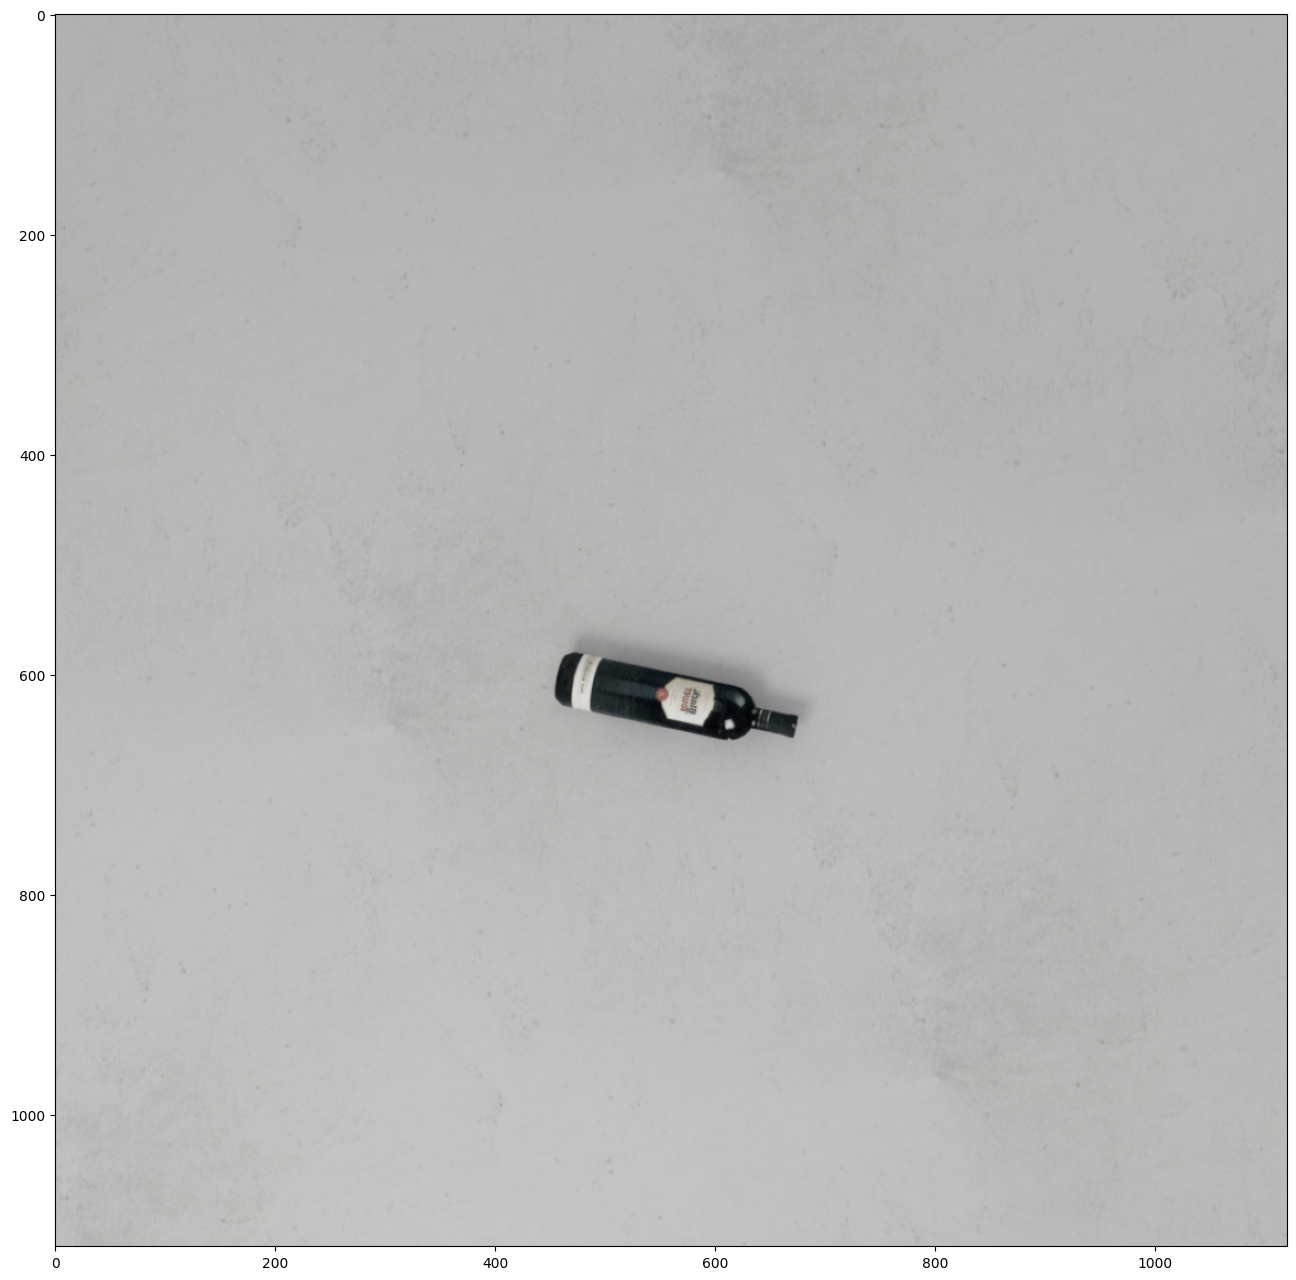

In [7]:
plt.figure(figsize=(16,16))
org_image = torch.permute(inv_transform(img), (1, 2, 0)).cpu().numpy()
plt.imshow(org_image)

# Test gt points certainty

In [8]:
all_points = grasp
mean_feats=[]
diffs = []
patch_area = 1
for i in range(all_points.shape[0]):
    pt1 = all_points[i,0,:]
    pt2 = all_points[i,1,:]
                    
    features_1 = features[pt1[0]:pt1[0]+patch_area, pt1[1]:pt1[1]+patch_area, :]
    features_1 = features_1.reshape(features_1.shape[0] * features_1.shape[1], features_1.shape[2]).mean(0)
    
    features_2 = features[pt2[0]:pt2[0]+patch_area, pt2[1]:pt2[1]+patch_area, :]
    features_2 = features_2.reshape(features_2.shape[0] * features_2.shape[1], features_2.shape[2]).mean(0)
    
                
    if i == 0:
        mean_feats = features_1.unsqueeze(0)
        mean_feats = torch.cat([mean_feats, features_2.unsqueeze(0)], dim=0)
    else:
        mean_feats = torch.cat([mean_feats, features_1.unsqueeze(0)], dim=0)
        mean_feats = torch.cat([mean_feats, features_2.unsqueeze(0)], dim=0)
with torch.no_grad():
    preds = model.forward_valid(mean_feats.to(device))

# Test single point

In [9]:

all_points = torch.tensor([[i,j] for j in range(PATCH_DIM) for i in range(PATCH_DIM)]).unsqueeze(1).to(device)
print(all_points.shape)
print(all_points[0])
#all_points = all_points.reshape(1,2,1)
#all_points = torch.cat([single_point, all_points], dim=1).to(device)

torch.Size([6400, 1, 2])
tensor([[0, 0]], device='cuda:0')


In [10]:
mean_feats=[]
diffs = []
patch_area = 1
for i in range(all_points.shape[0]):
    pt1 = all_points[i,0,:]
                    
    features_1 = features[pt1[0]:pt1[0]+patch_area, pt1[1]:pt1[1]+patch_area, :]
    features_1 = features_1.reshape(features_1.shape[0] * features_1.shape[1], features_1.shape[2]).mean(0)

                
    if i == 0:
        mean_feats = features_1.unsqueeze(0)
    else:
        mean_feats = torch.cat([mean_feats, features_1.unsqueeze(0)], dim=0)
with torch.no_grad():
    preds = model.forward_valid(mean_feats.to(device))

preds = preds.squeeze().reshape(PATCH_DIM, PATCH_DIM).unsqueeze(0).unsqueeze(0)
preds_patches = preds
zeros = torch.zeros(IMAGE_SIZE, IMAGE_SIZE, 1)
ones = torch.ones(IMAGE_SIZE, IMAGE_SIZE, 1)
print(preds.shape)
preds = torch.nn.functional.interpolate(preds, (IMAGE_SIZE, IMAGE_SIZE), mode="nearest").squeeze()
preds = torch.permute(preds, (1, 0))
preds = torch.cat([preds.cpu().detach().unsqueeze(2), zeros, zeros], dim = 2)

torch.Size([1, 1, 80, 80])


In [11]:
print(grasp.shape)
grasp_vis = torch.zeros((PATCH_DIM, PATCH_DIM))
for g in grasp:
        g1, g2 = g[0], g[1]
        grasp_vis[g1[0], g1[1]] = 1
        grasp_vis[g2[0], g2[1]] = 1
grasp_vis = grasp_vis.unsqueeze(0).unsqueeze(0)
grasp_vis = torch.nn.functional.interpolate(grasp_vis, (IMAGE_SIZE, IMAGE_SIZE), mode="nearest").squeeze()
zeros = torch.zeros(IMAGE_SIZE, IMAGE_SIZE, 1)
grasp_vis = torch.cat([zeros,grasp_vis.cpu().detach().unsqueeze(2), zeros], dim = 2)

torch.Size([96, 2, 2])


In [12]:
mask_vis = torch.zeros((PATCH_DIM, PATCH_DIM))
mask = mask.permute(0,2,1)
zero_indices = torch.nonzero(mask[0] == 0) // 14
one_indices = torch.nonzero(mask[0] == 1)  // 14

for idcs in one_indices:
    mask_vis[idcs[0], idcs[1]] = 1
mask_vis = mask_vis.unsqueeze(0).unsqueeze(0)
mask_vis = torch.nn.functional.interpolate(mask_vis, (IMAGE_SIZE, IMAGE_SIZE), mode="nearest").squeeze()
zeros = torch.zeros(IMAGE_SIZE, IMAGE_SIZE, 1)
mask_vis = torch.cat([mask_vis.cpu().detach().unsqueeze(2), zeros, zeros], dim = 2)

In [13]:
TOP_K = False
pts = None
if TOP_K : 
	preds_cp = preds_patches
	print(preds_cp.shape)

	k = 100
	flattened_tensor = preds_cp.flatten()
	# Find the top k values and their indices
	top_values, top_indices = torch.topk(flattened_tensor, k)

	# Create a mask tensor where the top k values are True and the rest are False
	mask = torch.zeros_like(flattened_tensor)
	mask[top_indices] = 1.
	mask = mask.reshape(preds_cp.shape)
	mask = mask.permute(0,1,3,2)
	print(mask.shape)
	mask = torch.nn.functional.interpolate(mask, (IMAGE_SIZE, IMAGE_SIZE), mode="nearest").squeeze()
	preds_cp = torch.cat([mask.unsqueeze(2),ones, zeros], dim = 2)
	pts = top_indices


else : 
    preds_cp = preds.clone()
    thresh = 0.9
    preds_cp[preds_cp < thresh] = 0
    preds_cp[preds_cp >= thresh] = 1
    pts = (preds_cp == 1).nonzero() 


In [14]:
valid_pts_pred = pts[:, 0:2] // 14
valid_pts_pred = torch.unique(valid_pts_pred, dim=0)
valid_pts_pred = valid_pts_pred.reshape(-1, 1,2) 
#valid_pts_pred

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


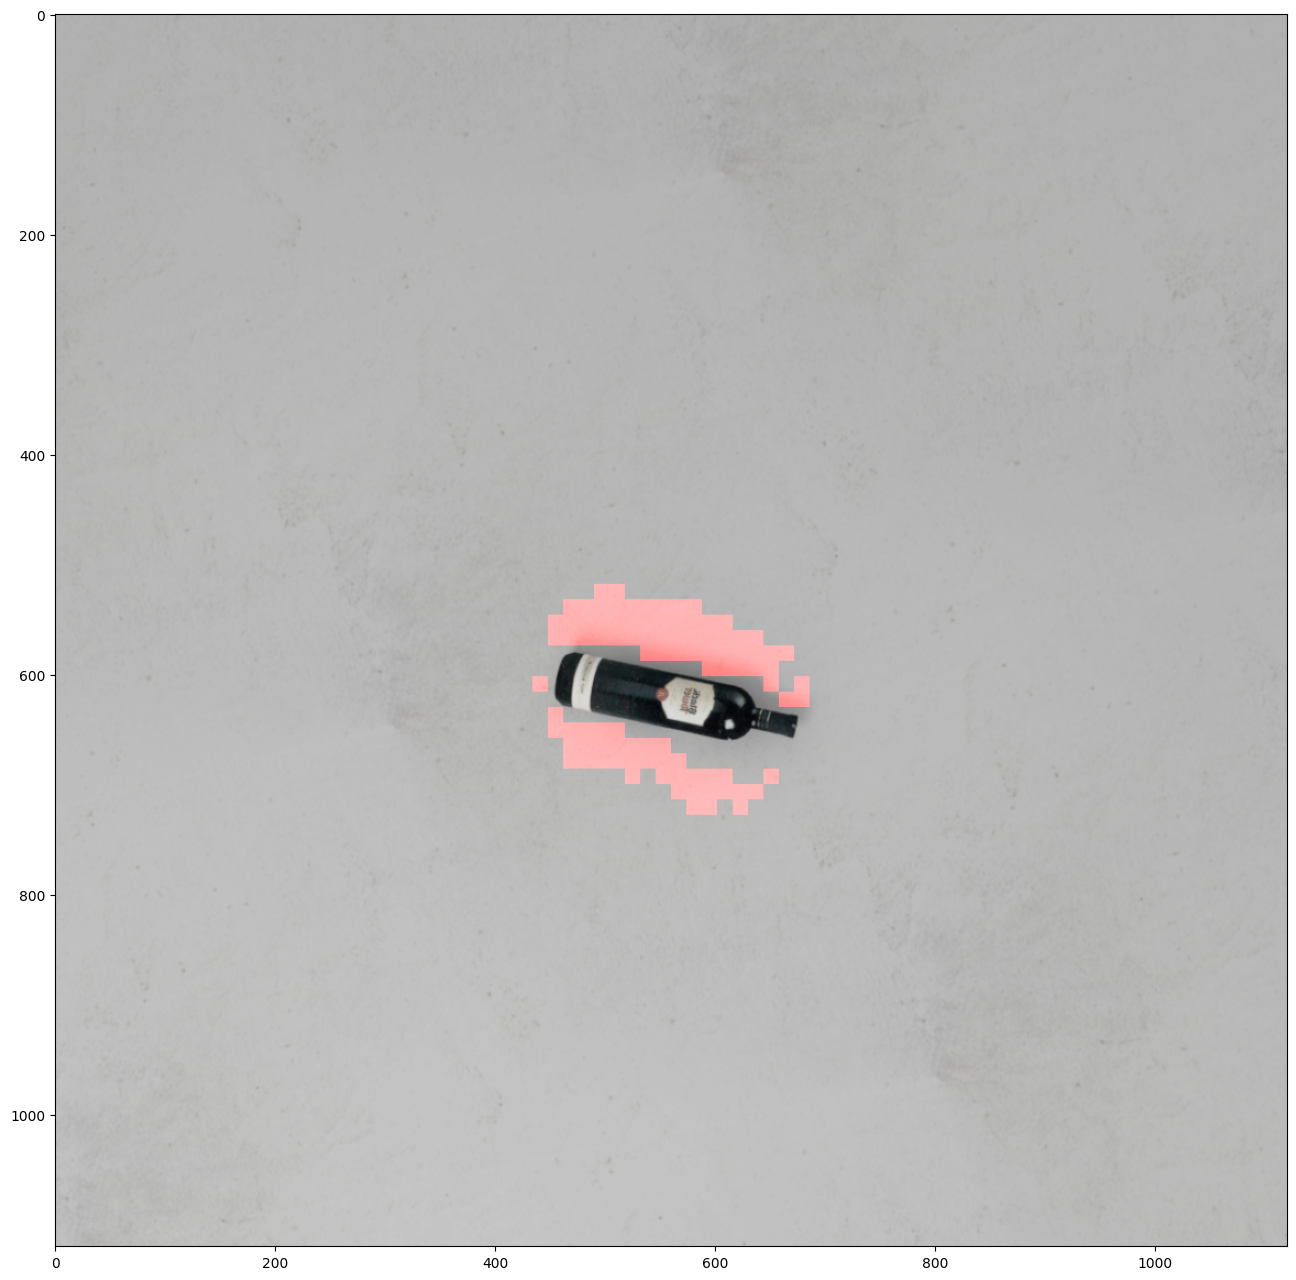

In [15]:


#origin_point = np.zeros((3, 60, 60))
#origin_point[:, single_point[0][0][0], single_point[0][0][1]] = [0, 1, 0]
#origin_point = torch.nn.functional.interpolate(torch.tensor(origin_point).unsqueeze(0), (840, 840), mode="nearest").squeeze()
#origin_point = torch.permute(origin_point,(1, 2, 0)).cpu().detach().numpy()
plt.figure(figsize=(16,16))
show_img = org_image + 0.7*preds_cp.cpu().detach().numpy()# + 0.5 * grasp_vis.numpy() 
#show_img = org_image + 0.5 * grasp_vis.numpy() + 0.5 * mask_vis.numpy()
#show_img = org_image + 0.7*origin_point2 + 0.7*origin_point
plt.imshow(show_img)

### Get the second point that corresponds

In [16]:
from infer_utils import get_features, test_single_point, test_single_point_constraint

args_infer_single = {
    "model_path" : "runs/bce_grasp_bottle_mask4.ckpt",
    "device" : "cuda",
    "img_size" : 1120
}


In [17]:
device = torch.device(args_infer["device"])
image_transform = get_transform()
inv_transform = get_inv_transform()
model_single = BCEGraspTransformer(img_size=args_infer_single["img_size"])
model_single.load_state_dict(torch.load(args_infer_single["model_path"]))
model_single = model_single.to(device)

max_dist =0
min_dist = 999999
for i in range(4):
    data = dataset[i]
    mask = data["mask"].sum().sqrt()
    all_points = data["points_grasp"]//14
    dif = (all_points[:, 0, :] - all_points[:, 1, :]).type(torch.float32).norm(p=2, dim=1)
    dif_n = (dif/mask).unsqueeze(1)
    if max_dist < dif_n.max():
        max_dist = dif_n.max()
    if min_dist > dif_n.min():
        min_dist = dif_n.min()


In [18]:
img, mask, grasp, features,heights,corners = get_features(dataset, model_single, device, args_infer_single, test_idx)
org_image = torch.permute(inv_transform(img), (1, 2, 0)).cpu().numpy()
mask_n = mask.sum().sqrt()
mask = torch.nn.functional.interpolate(mask.unsqueeze(0), (args_infer_single["img_size"]//14, args_infer_single["img_size"]//14), mode="nearest").squeeze()
mask = mask.reshape((args_infer["img_size"]//14)**2)
mask = mask>0

In [19]:
from shapely.geometry import Polygon

def create_oriented_bounding_box(point1, point2, h):
    direction_vector = point2 - point1
    direction_vector /= torch.norm(direction_vector.to(torch.float32))

    perpendicular_vector = torch.tensor([direction_vector[1], -direction_vector[0]])
    scaled_perpendicular_vector = h * perpendicular_vector

    corner_points = torch.stack(
        [
            point1 + scaled_perpendicular_vector,
            point1 - scaled_perpendicular_vector,
            point2 - scaled_perpendicular_vector,
            point2 + scaled_perpendicular_vector,
        ]
    )

    return corner_points

def oriented_bounding_box_iou(box1, box2):
    # Convert tensors to lists
    box1 = box1.tolist()
    box2 = box2.tolist()

    # Create polygons from the corner points
    poly1 = Polygon(box1)
    poly2 = Polygon(box2)

    # Calculate intersection area
    intersection = poly1.intersection(poly2).area

    # Calculate union area
    union = poly1.area + poly2.area - intersection

    # Compute IoU
    iou = intersection / (union + 1e-6)
   

    return iou


def grasp_correct_full(pred_point, single_point, gt_grasp,heights,thresh_angle=30,thresh_iou=0.25):
        '''
        given the input point single_point we check if the second point is a valid grasp 
        for that : 
        1) angle difference is less than 30 degress 
        2) the IOU of the points is at least 0.25 
        '''
        
        angle_flag = False
        iou_flag = False
        
        ##1) angle verifier 
        vec_pred_to_single = pred_point - single_point #vector of the prediction grasps 
        vec_single_to_gt = gt_grasp[0] - gt_grasp[1] #vector of the ground truth grasps
        vec_single_to_gt_rev = gt_grasp[1] - gt_grasp[0] #vector of the ground truth grasps

        
        dot_product = torch.dot(vec_pred_to_single.to(torch.float64), vec_single_to_gt.to(torch.float64))
        dot_product_rev = torch.dot(vec_pred_to_single.to(torch.float64), vec_single_to_gt_rev.to(torch.float64))

        # Calculate the magnitudes of the vectors
        magnitude_pred_to_single = torch.norm(vec_pred_to_single.to(torch.float64))
        magnitude_single_to_gt = torch.norm(vec_single_to_gt.to(torch.float64))
        magnitude_single_to_gt_rev = torch.norm(vec_single_to_gt_rev.to(torch.float64))

        # Calculate the cosine of the angle between the vectors
        cos_angle = dot_product / (magnitude_pred_to_single * magnitude_single_to_gt)
        cos_angle_rev = dot_product_rev / (magnitude_pred_to_single * magnitude_single_to_gt_rev)

        # Calculate the angle in radians
        correct = False
        angle_radians = torch.acos(cos_angle)
        angle_radians_rev = torch.acos(cos_angle_rev)

        # Convert the angle to degrees
        angle_degrees = angle_radians * (180.0 / torch.pi)
        angle_degrees_rev = angle_radians_rev * (180.0 / torch.pi)
        #print("angle_degrees", angle_degrees)
        #print("angle_degrees_rev", angle_degrees_rev)
        
        if angle_degrees < thresh_angle or angle_degrees_rev < thresh_angle:        
                angle_flag = True
        
        
        
        corner_points_gt = create_oriented_bounding_box(gt_grasp[0].to(torch.float32),gt_grasp[1].to(torch.float32),heights)
        corner_points_pred = create_oriented_bounding_box(single_point.to(torch.float32),pred_point.to(torch.float32),heights)
        
        iou = oriented_bounding_box_iou(corner_points_gt, corner_points_pred)
        
        
        if iou >= thresh_iou:
                iou_flag = True
        
        if angle_flag == True and iou_flag == True:
                correct = True
        print('-----')
        return corner_points_gt, corner_points_pred, correct, iou, min(angle_degrees,angle_degrees_rev)
        

In [20]:
objs = valid_pts_pred.shape[0]
#objs = 1
constrain_mode = False
if constrain_mode == False and objs != 1:
    objs = int(objs / 2)
##currently only support constraint mode == false
items = []
top_k_preds = 5 if objs != 1 else 1


for point_idx in range(objs):
    
    if constrain_mode == True : 
        preds, diff_n, single_point, single_point_gt = test_single_point_constraint(valid_pts_pred, mask_n, device, features, model_single, args_infer, point_idx,constrain_mode=constrain_mode)
    

        th_p = diff_n>max_dist
        th_n = diff_n<min_dist
        th = th_p + th_n
        preds[th] = 0.


        topk=1
        if topk != 0:
            topk, ind = torch.topk(preds, topk)
            ind = ind.cpu()
            if constrain_mode == False : 
                preds = torch.zeros(6400)
                preds[ind] = 1
        preds = preds.reshape(args_infer["img_size"]//14, args_infer["img_size"]//14).unsqueeze(0).unsqueeze(0)
        
        top_x = 0
        top_y = 0 
        if constrain_mode == True :
            top_y , top_x = valid_pts_pred[ind,0,0].item(), valid_pts_pred[ind,0,1].item()
            preds[0,0,top_x,top_y] = 0 
        preds = torch.nn.functional.interpolate(preds, (args_infer["img_size"], args_infer["img_size"]), mode="nearest").squeeze()
        preds = torch.permute(preds, (1, 0))


        zeros = torch.zeros(args_infer_single["img_size"], args_infer_single["img_size"], 1)
        ones = torch.ones(args_infer_single["img_size"], args_infer_single["img_size"], 1)
        preds = torch.cat([preds.cpu().detach().unsqueeze(2), zeros, zeros], dim = 2)
        origin_point = np.zeros((3, args_infer["img_size"]//14, args_infer["img_size"]//14))
        origin_point[:, single_point[0][0][0], single_point[0][0][1]] = [0, 1, 0]
        if constrain_mode == True : 
            origin_point[:, top_y, top_x] = [0, 1, 1]
        origin_point = torch.nn.functional.interpolate(torch.tensor(origin_point).unsqueeze(0), (args_infer["img_size"], args_infer["img_size"]), mode="nearest").squeeze()
        origin_point = torch.permute(origin_point,(1, 2, 0)).cpu().detach().numpy()

        plt.figure(figsize=(16,16))
        #show_img = org_image + 0.7*preds.cpu().detach().numpy() + 0.7*origin_point + 0.3 * preds_cp.cpu().detach().numpy()
        if constrain_mode == True : 
            show_img = org_image + 0.7*preds_cp.cpu().detach().numpy() + 0.9*origin_point 
        else : 
            show_img = org_image + 0.7*preds.cpu().detach().numpy() + 0.9*origin_point 
        #show_img = org_image + 0.7*origin_point2 + 0.7*origin_point
        plt.imshow(show_img)
        plt.title("point x : {}, point y : {}".format(single_point[0][0][1],single_point[0][0][0]))
    
    else :    
        single_point = None 
        preds, diff_n, single_point, single_point_gt, height = test_single_point(valid_pts_pred.reshape(-1,2,2), mask_n, 
                                    device, features, model_single, args_infer, point_idx,heights,single_point=None)
        
        
        th_p = diff_n>max_dist
        th_n = diff_n<min_dist
        th = th_p + th_n
        preds[th] = 0.
        preds[mask] = 0.
        topk=1
        if topk != 0:
            topk, ind = torch.topk(preds, topk)
            ind = ind.cpu()
            conf = preds[ind]
            preds = torch.zeros(6400)
            
            
            
            preds[ind] = 1
        
        x, y = ind// (args_infer["img_size"]//14), ind % (args_infer["img_size"]//14)
        pred_point = torch.Tensor([y.item(), x.item()]).to(torch.int64) * 14 + 7  ## predicted second point 
        input_point = single_point[0,0] * 14 + 7## single input point prediction => input prediction 
        preds = preds.reshape(args_infer["img_size"]//14, args_infer["img_size"]//14).unsqueeze(0).unsqueeze(0)

        
        preds = torch.nn.functional.interpolate(preds, (args_infer["img_size"], args_infer["img_size"]), mode="nearest").squeeze()
        preds = torch.permute(preds, (1, 0))
        zeros = torch.zeros(args_infer["img_size"], args_infer["img_size"], 1)
        preds = torch.cat([preds.cpu().detach().unsqueeze(2), zeros, zeros], dim = 2)
        origin_point = np.zeros((3, args_infer["img_size"]//14, args_infer["img_size"]//14))
        origin_point[:, single_point[0][0][0], single_point[0][0][1]] = [0, 1, 0]
        #origin_point[:, single_point_gt[0][0][0], single_point_gt[0][0][1]] = [0, 0, 1] gt is uncommented as it just delivers a random point
        
        
        origin_point = torch.nn.functional.interpolate(torch.tensor(origin_point).unsqueeze(0), (args_infer["img_size"], 
                                                args_infer["img_size"]), mode="nearest").squeeze()
        
        item = {}
        item['origin_point'] = origin_point
        item['preds'] = preds
        item['single_point'] = single_point[0,0] * 14 + 7
        item['pred_point'] = pred_point
        item['conf'] = conf.item()
        
        items.append(item)


/home/cedric/anaconda3/envs/4D-humans/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


angle_degrees tensor(169.5085, dtype=torch.float64)
angle_degrees_rev tensor(10.4915, dtype=torch.float64)
-----
angle_degrees tensor(169.5085, dtype=torch.float64)
angle_degrees_rev tensor(10.4915, dtype=torch.float64)
-----
angle_degrees tensor(169.5085, dtype=torch.float64)
angle_degrees_rev tensor(10.4915, dtype=torch.float64)
-----
angle_degrees tensor(169.5085, dtype=torch.float64)
angle_degrees_rev tensor(10.4915, dtype=torch.float64)
-----
angle_degrees tensor(169.5085, dtype=torch.float64)
angle_degrees_rev tensor(10.4915, dtype=torch.float64)
-----
angle_degrees tensor(180.0000, dtype=torch.float64)
angle_degrees_rev tensor(1.2074e-06, dtype=torch.float64)
-----
angle_degrees tensor(180.0000, dtype=torch.float64)
angle_degrees_rev tensor(1.2074e-06, dtype=torch.float64)
-----
angle_degrees tensor(180.0000, dtype=torch.float64)
angle_degrees_rev tensor(1.2074e-06, dtype=torch.float64)
-----
angle_degrees tensor(180.0000, dtype=torch.float64)
angle_degrees_rev tensor(1.2074e-06

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-----
angle_degrees tensor(158.1986, dtype=torch.float64)
angle_degrees_rev tensor(21.8014, dtype=torch.float64)
-----
angle_degrees tensor(21.8014, dtype=torch.float64)
angle_degrees_rev tensor(158.1986, dtype=torch.float64)
-----
angle_degrees tensor(21.8014, dtype=torch.float64)
angle_degrees_rev tensor(158.1986, dtype=torch.float64)
-----
angle_degrees tensor(21.8014, dtype=torch.float64)
angle_degrees_rev tensor(158.1986, dtype=torch.float64)
-----
angle_degrees tensor(21.8014, dtype=torch.float64)
angle_degrees_rev tensor(158.1986, dtype=torch.float64)
-----
angle_degrees tensor(21.8014, dtype=torch.float64)
angle_degrees_rev tensor(158.1986, dtype=torch.float64)
-----
angle_degrees tensor(11.3099, dtype=torch.float64)
angle_degrees_rev tensor(168.6901, dtype=torch.float64)
-----
angle_degrees tensor(11.3099, dtype=torch.float64)
angle_degrees_rev tensor(168.6901, dtype=torch.float64)
-----
angle_degrees tensor(11.3099, dtype=torch.float64)
angle_degrees_rev tensor(168.6901, dtyp

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Accuracy is 100.0 %


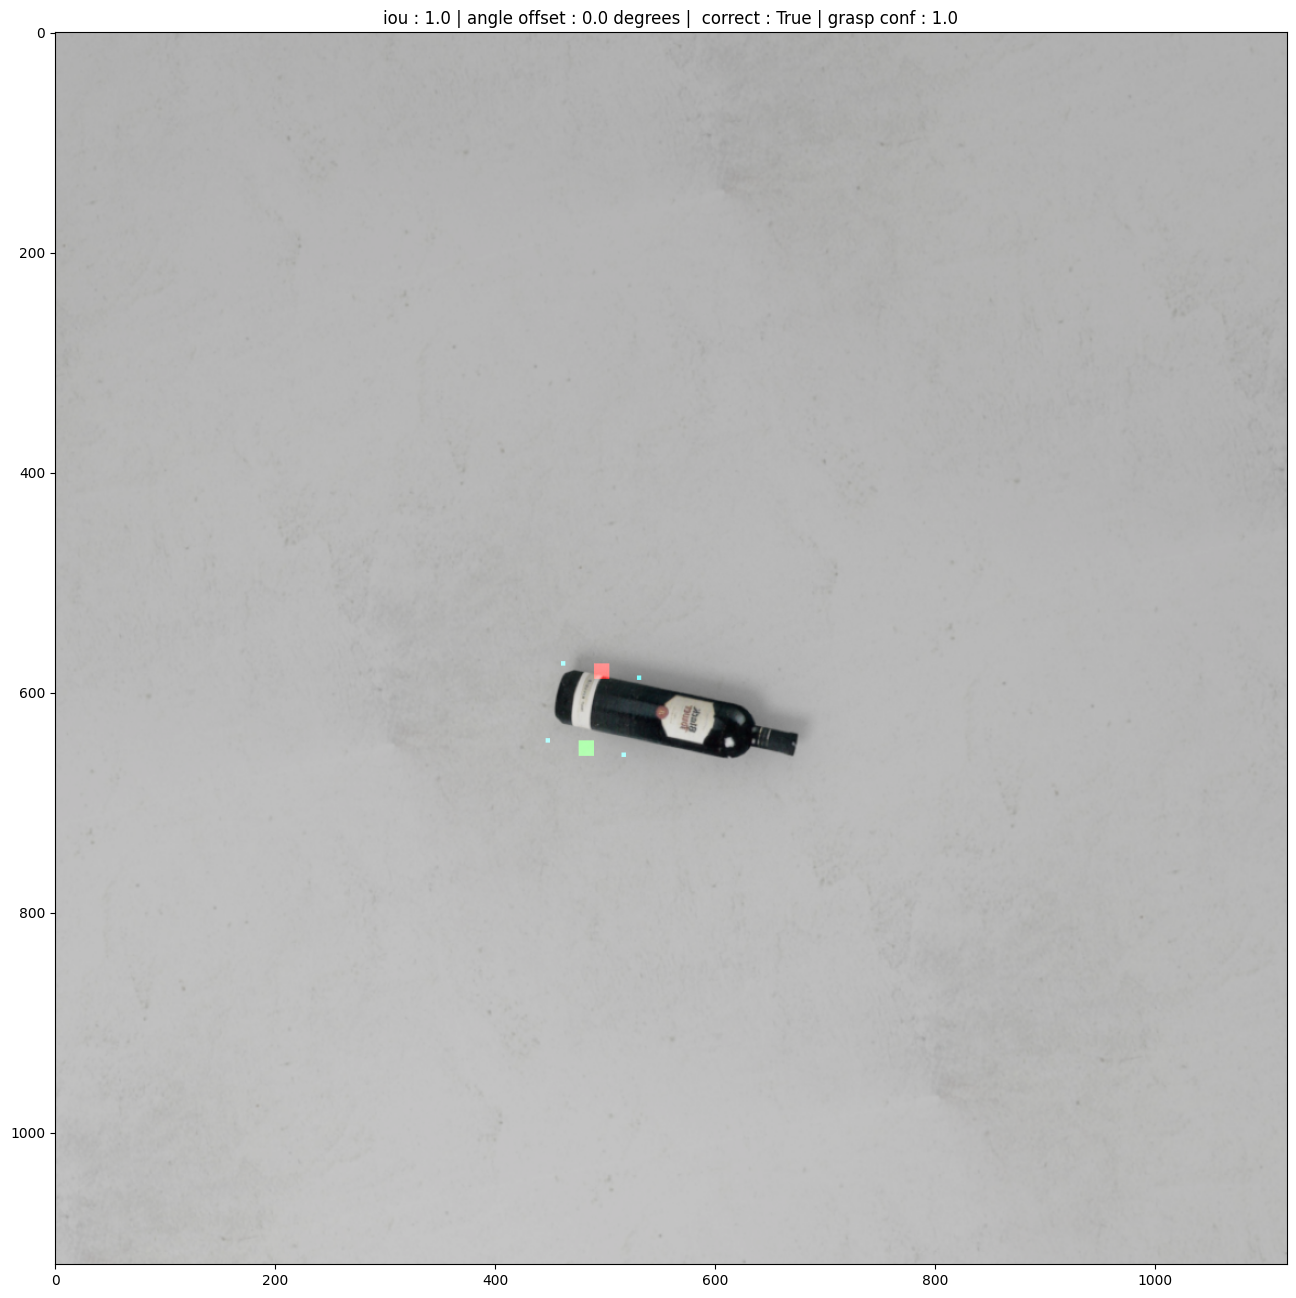

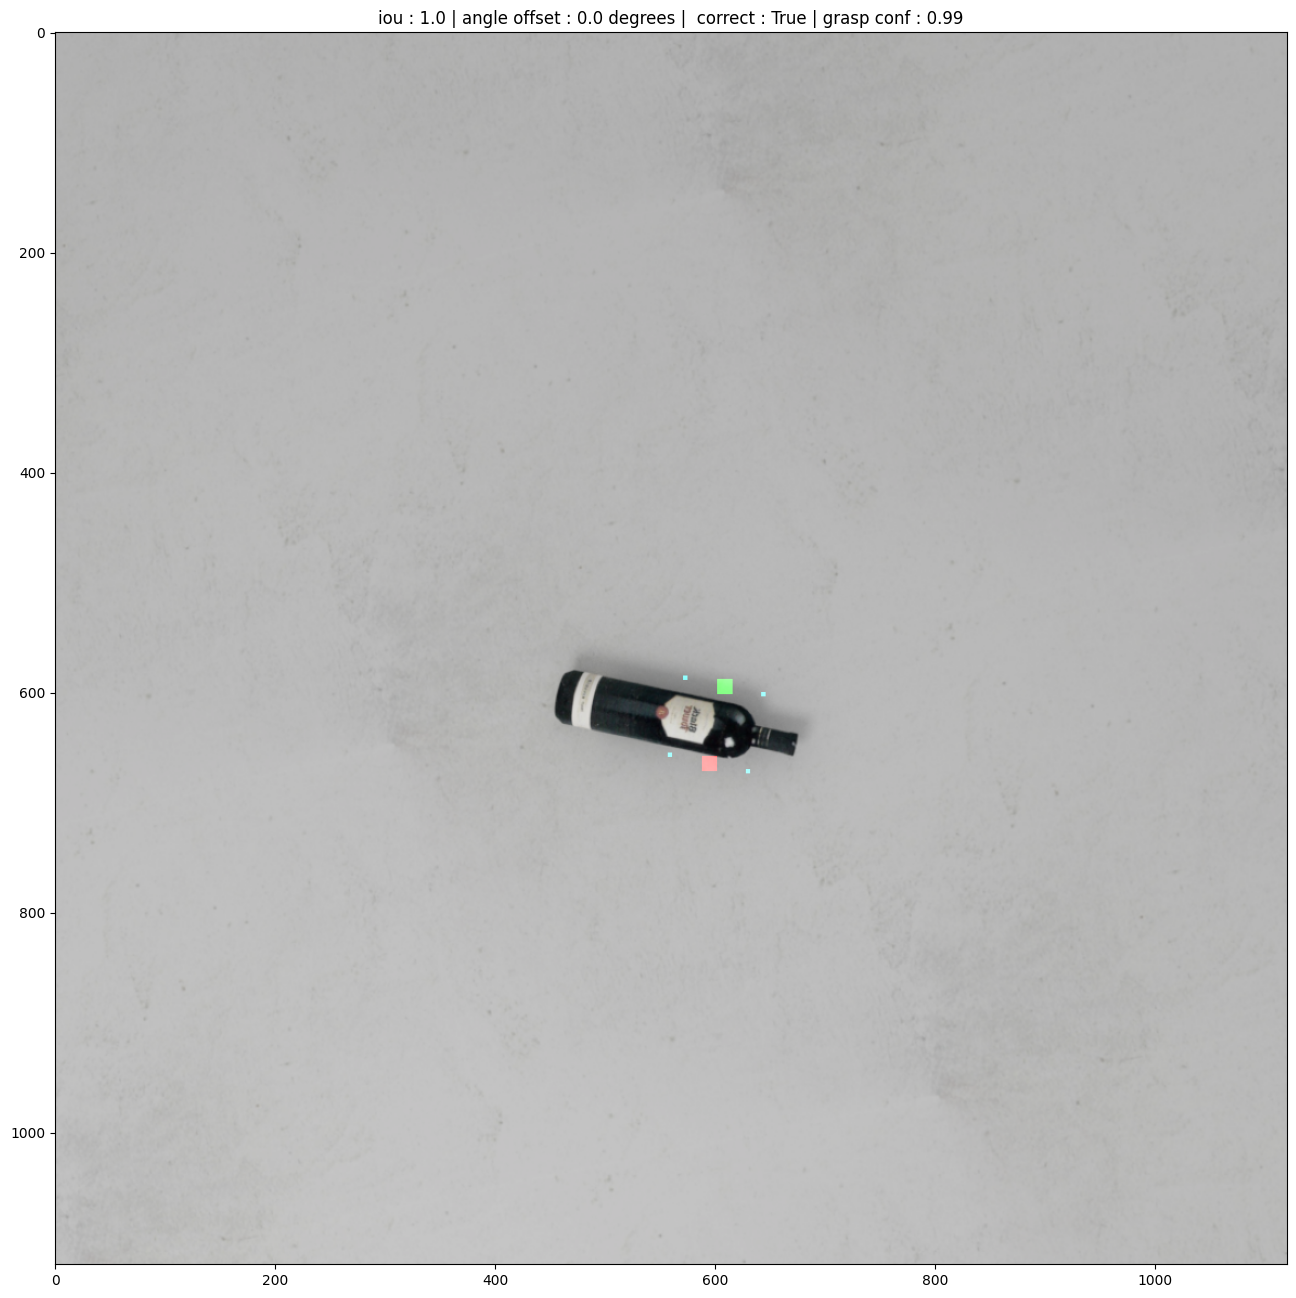

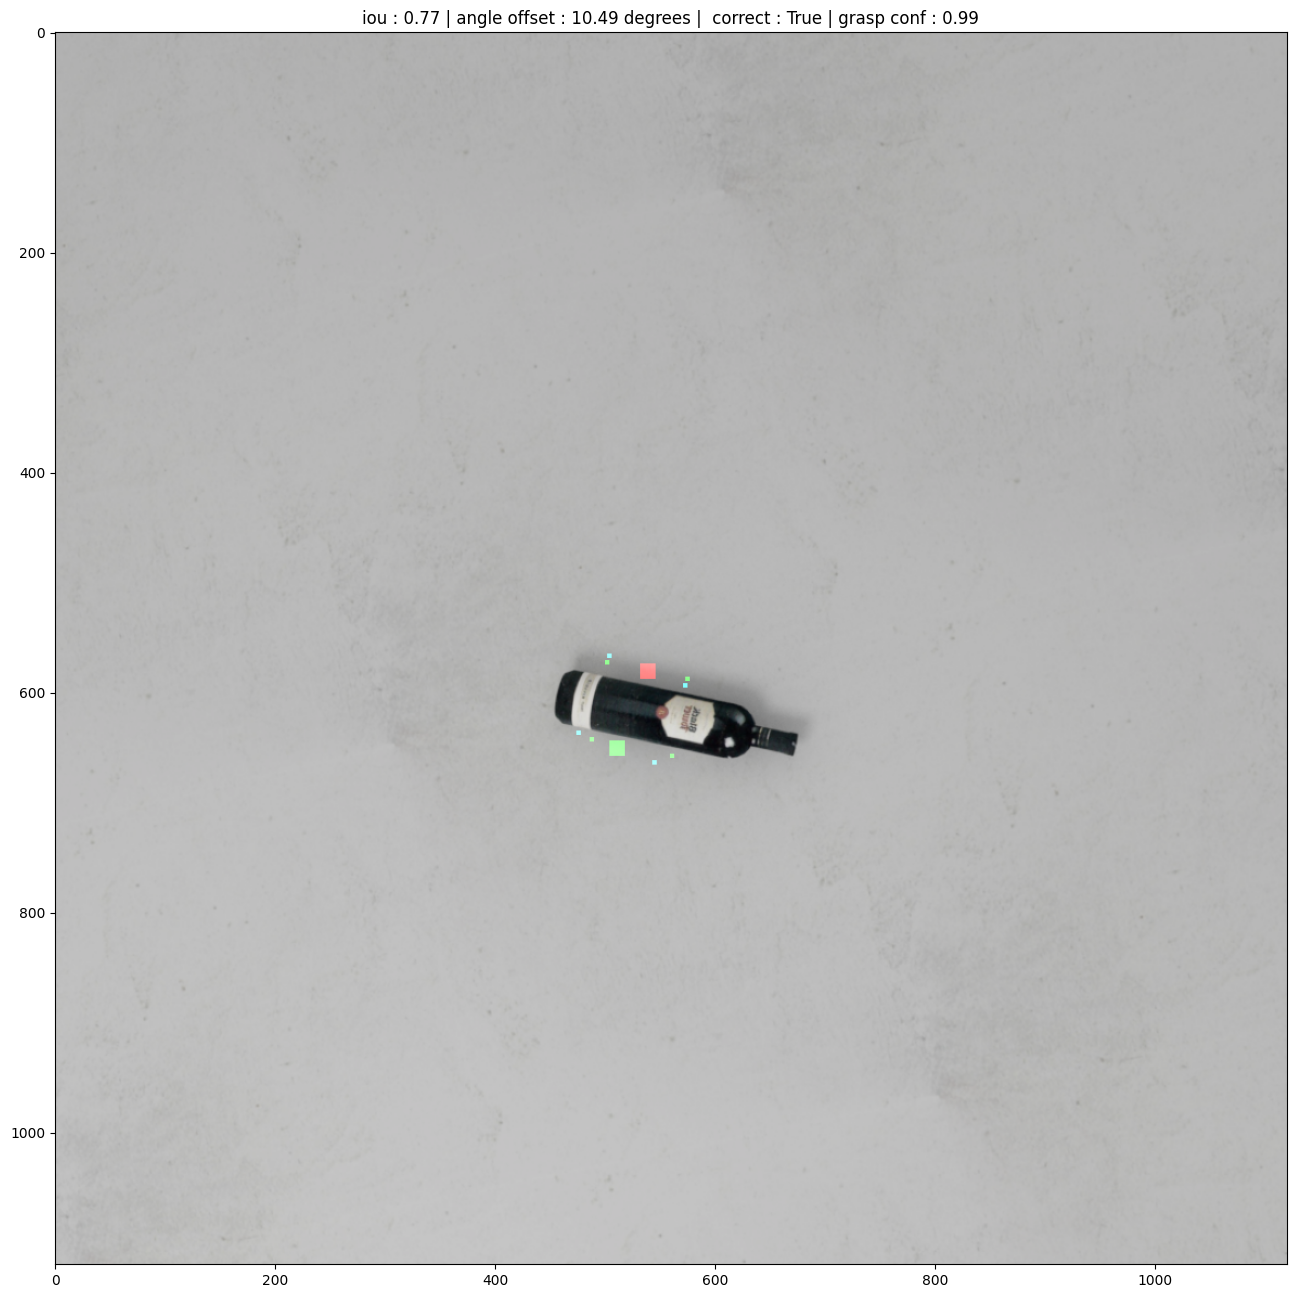

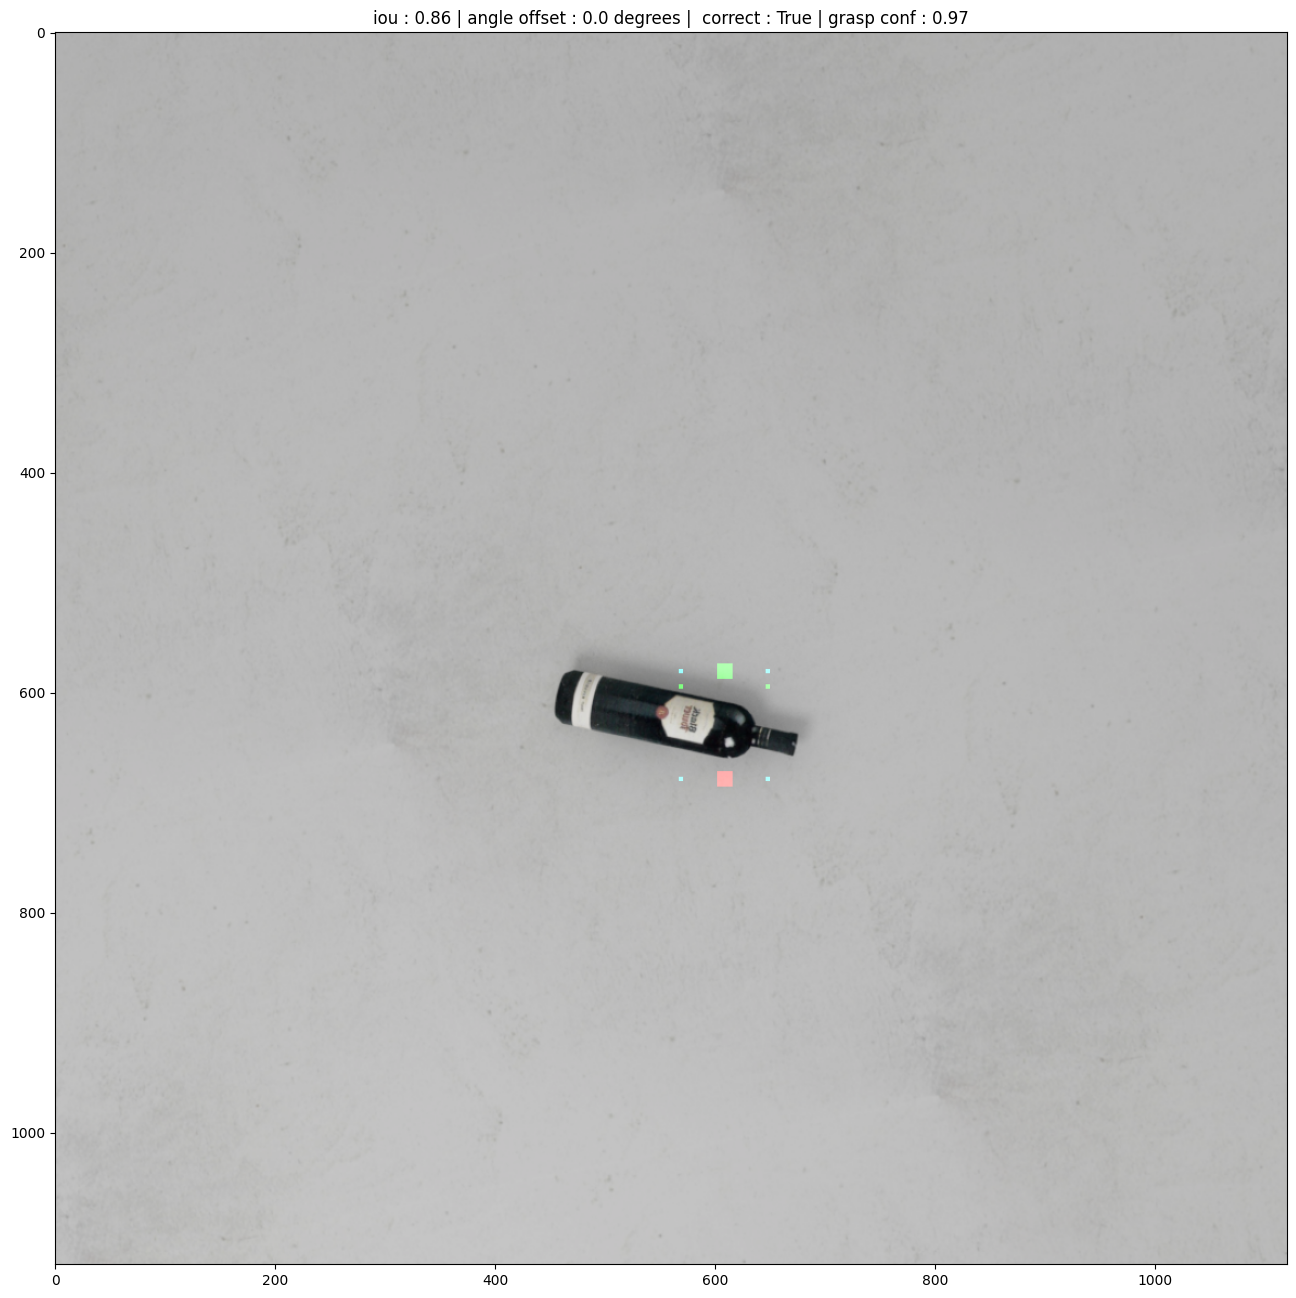

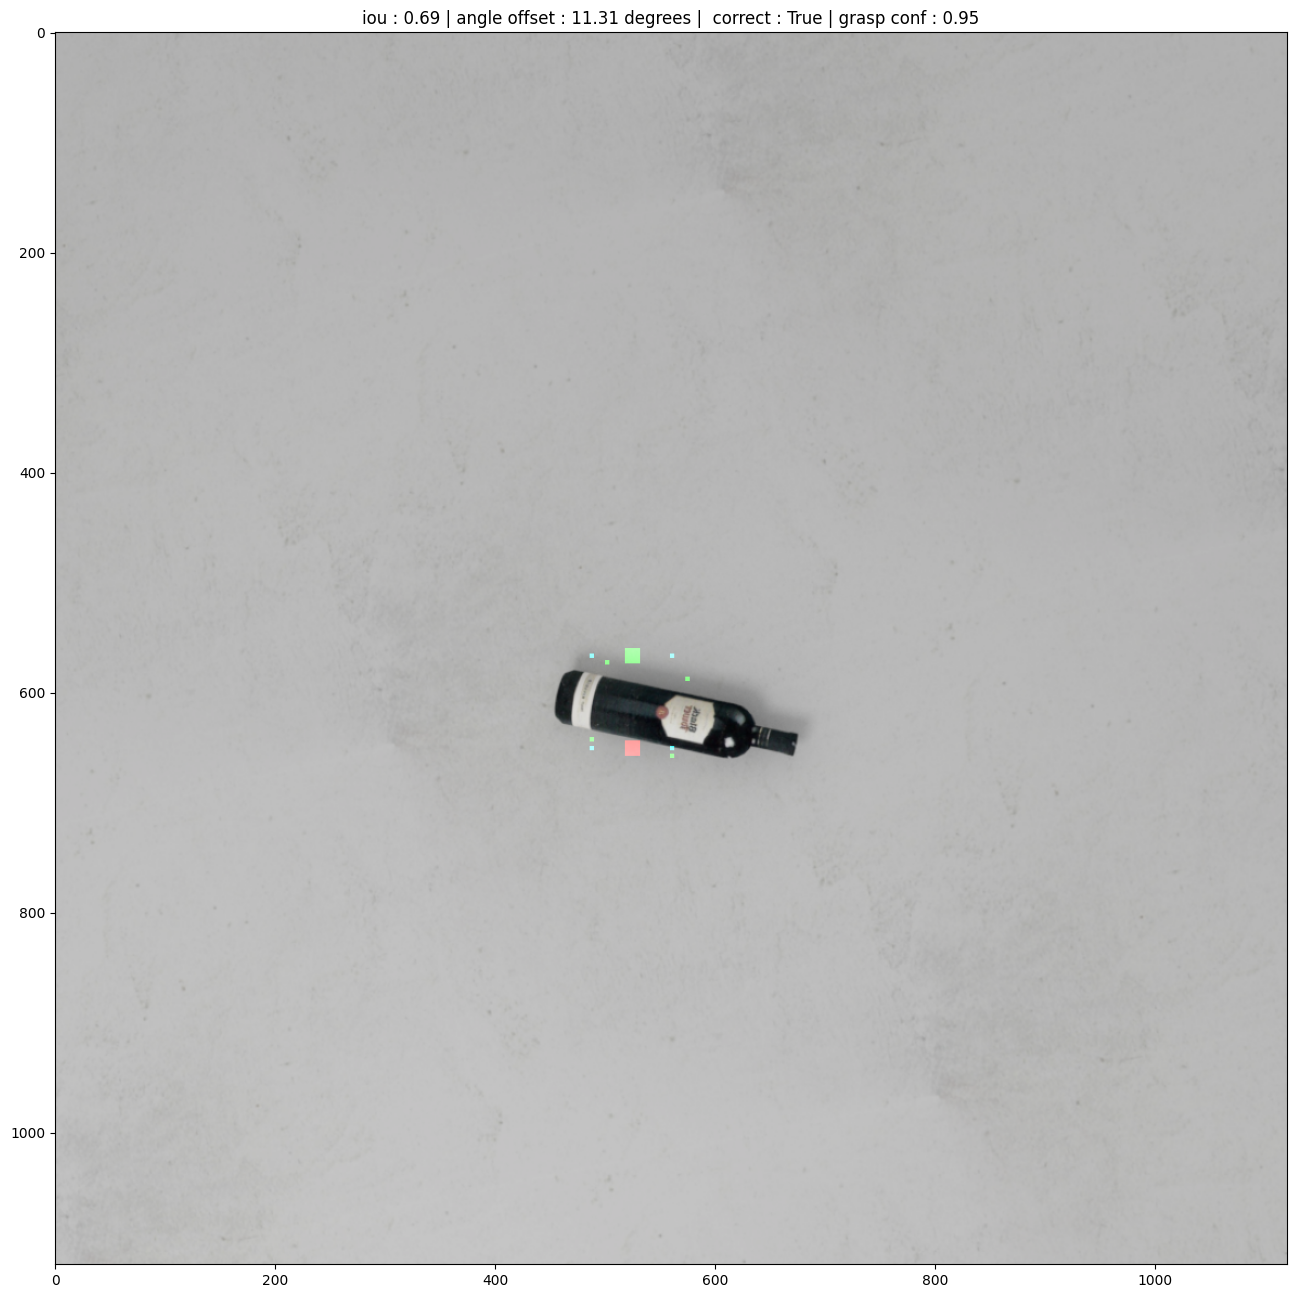

In [21]:
items = sorted(items, key=lambda x: x['conf'], reverse=True)
total_cnt, correct_cnt = 0, 0
for i in range(top_k_preds): 
    preds = items[i]['preds']
    origin_point = items[i]['origin_point']
    single_point = items[i]['single_point'] 
    pred_point = items[i]['pred_point'] 
    conf = items[i]['conf']
    correct_end = False
    plt.figure(figsize=(16,16))
    best_iou, best_idx = -1,0
    best_corner_pts = None
    best_corner_preds = None
    best_angle_diff = 1000
    for gt_idx in range(int(grasp.shape[0] // 2.)): 
                grasp_cur = grasp[gt_idx] * 14 + 7
                corner_points, corner_points_pred, correct, iou, angle_diff = grasp_correct_full(single_point, pred_point, 
                                                                grasp_cur,heights[gt_idx] /2. * args_infer["img_size"] )
                
                
                if correct == True :
                    correct_end = True
                
                if correct_end == True :
                    if iou > best_iou and correct == True :
                        best_iou = iou
                        best_idx = gt_idx
                        best_angle_diff = angle_diff
                        best_corner_pts = corner_points.clone()
                        best_corner_preds = corner_points_pred.clone()

                        
                else : 
                    if iou > best_iou :
                        best_iou = iou
                        best_idx = gt_idx
                        best_angle_diff = angle_diff
                        best_corner_pts = corner_points.clone()
                        best_corner_preds = corner_points_pred.clone()

    if correct_end == True :
        correct_cnt += 1
    total_cnt += 1
    
    for pt in best_corner_pts : 
        new_x = int(pt[0]) 
        new_y = int(pt[1])
        boarder = 2
        origin_point[:,new_x - boarder : new_x + boarder , new_y - boarder: new_y + boarder] = torch.zeros((3,boarder*2,boarder*2)) 
        origin_point[1,new_x - boarder : new_x + boarder , new_y - boarder: new_y + boarder] = torch.ones((boarder*2,boarder*2)) 
    
    for pt in best_corner_preds : 
            new_x = int(pt[0]) 
            new_y = int(pt[1])
            boarder = 2
            origin_point[:,new_x - boarder : new_x + boarder , new_y - boarder: new_y + boarder] = torch.ones((3,boarder*2,boarder*2)) 
            origin_point[0,new_x - boarder : new_x + boarder , new_y - boarder: new_y + boarder] = torch.zeros((boarder*2,boarder*2)) 
    
    #origin_point[:,single_point[0] - 2 : single_point[0] + 2 , single_point[1] - 2: single_point[1] + 2] = torch.ones((3,4,4)) * 0.5
    #origin_point[:,pred_point[0] - 2 : pred_point[0] + 2 , pred_point[1] - 2: pred_point[1] + 2] = torch.ones((3,4,4)) * 0.5
    
    origin_point = torch.permute(origin_point,(1, 2, 0)).cpu().detach().numpy()
    show_img = org_image + 0.7*preds.cpu().detach().numpy() + 0.7*origin_point
    #show_img = org_image + 0.7*origin_point2 + 0.7*origin_point
    plt.imshow(show_img)
    plt.title("iou : {} | angle offset : {} degrees |  correct : {} | grasp conf : {}".format(round(best_iou,2),round(best_angle_diff.item(),2)  , correct_end, round(conf,2)))

print("Accuracy is {} %".format(round(correct_cnt / total_cnt * 100,2)))